In [1]:
import matplotlib.pyplot as plt

plt.rc('font', family='serif', size=14, serif='STIXGeneral')
plt.rc('mathtext', fontset='stix')

import phoebe
import numpy as np

logger = phoebe.logger('error')

# we'll set the random seed so that the noise model is reproducible
np.random.seed(123456789)

PHOEBE: passband "Bolometric:900-40000" has a newer version available.  Run phoebe.list_passband_online_history("Bolometric:900-40000") to get a list of available changes and phoebe.update_passband("Bolometric:900-40000") or phoebe.update_all_passbands() to update.
PHOEBE: passband "Johnson:V" has a newer version available.  Run phoebe.list_passband_online_history("Johnson:V") to get a list of available changes and phoebe.update_passband("Johnson:V") or phoebe.update_all_passbands() to update.


In [2]:
#Creating fake set of observations

b = phoebe.default_binary()
b.set_value('ecc', 0.2)
b.set_value('per0', 25)
b.set_value('teff@primary', 7000)
b.set_value('teff@secondary', 6000)
b.set_value('sma@binary', 7)
b.set_value('incl@binary', 80)
b.set_value('q', 0.3)
b.set_value('t0_supconj', 0.1)
b.set_value('requiv@primary', 2.0)
b.set_value('vgamma', 80)

lctimes = phoebe.linspace(0, 10, 1005)
rvtimes = phoebe.linspace(0, 10, 105)
b.add_dataset('lc', compute_times=lctimes)
b.add_dataset('rv', compute_times=rvtimes)

b.add_compute('ellc', compute='fastcompute')
b.set_value_all('ld_mode', 'lookup')
b.run_compute(compute='fastcompute')

fluxes = b.get_value('fluxes@model') + np.random.normal(size=lctimes.shape) * 0.01
fsigmas = np.ones_like(lctimes) * 0.02

rvsA = b.get_value('rvs@primary@model') + np.random.normal(size=rvtimes.shape) * 10
rvsB = b.get_value('rvs@secondary@model') + np.random.normal(size=rvtimes.shape) * 10
rvsigmas = np.ones_like(rvtimes) * 20

100%|██████████| 3/3 [00:00<00:00, 35.49it/s]


In [3]:
#Create new bundle and import "fake" observations
b = phoebe.default_binary()

b.set_value('latex_repr', component='binary', value='orb')
b.set_value('latex_repr', component='primary', value='1')
b.set_value('latex_repr', component='secondary', value='2')

b.add_dataset('lc', 
              compute_phases=phoebe.linspace(0,1,201),
              times=lctimes, 
              fluxes=fluxes, 
              sigmas=fsigmas, 
              dataset='lc01')

b.add_dataset('rv', 
              compute_phases=phoebe.linspace(0,1,201),
              times=rvtimes, 
              rvs={'primary': rvsA, 'secondary': rvsB}, 
              sigmas=rvsigmas, 
              dataset='rv01')

b.set_value_all('ld_mode', 'lookup')

/home/nadiabolef/contactBinaries/venv/lib/python3.10/site-packages/phoebe/dependencies/autofig/call.py:1305: UserWarning: You passed a edgecolor/edgecolors ('none') for an unfilled marker ('+').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  artist = ax.scatter(*datapoint,


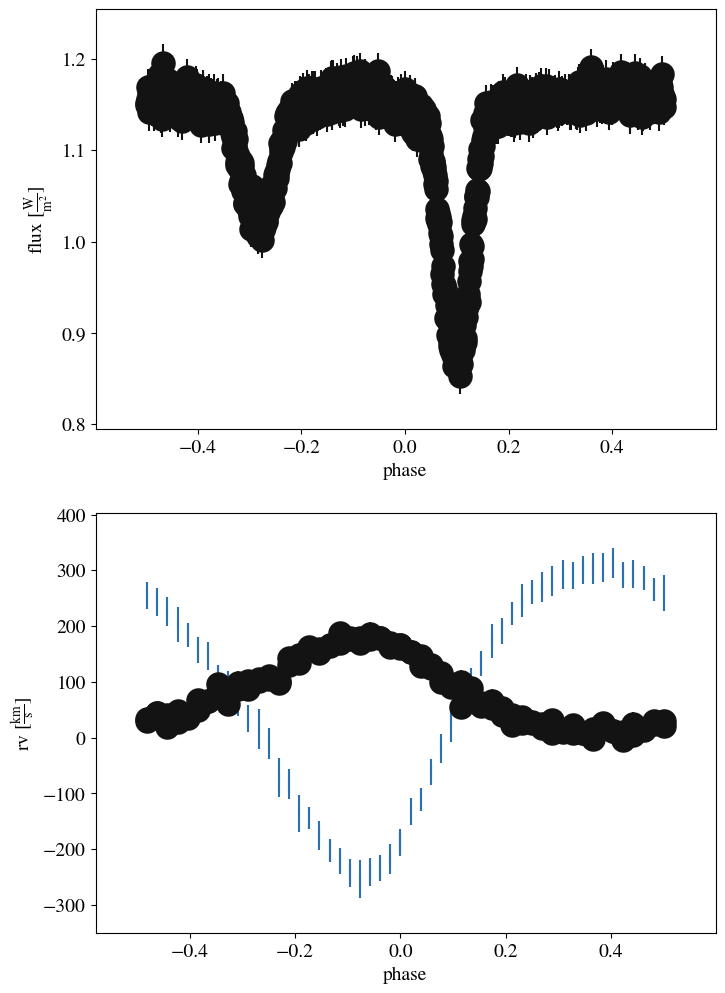

In [4]:
#Assume we know the exact orbital period
afig, mplfig = b.plot(x='phases', show=True)

In [5]:
#radial velocity geometry esimator

b.add_solver('estimator.rv_geometry',
             rv_datasets='rv01',
             solver='rvgeom_solver')

<ParameterSet: 7 parameters | qualifiers: expose_model, phase_bin, orbit, use_server, rv_datasets, phase_nbins, comments>

In [6]:
b.run_solver(kind='rv_geometry', solution='rv_geom_sol')

/home/nadiabolef/contactBinaries/venv/lib/python3.10/site-packages/scipy/optimize/_lsq/common.py:115: RuntimeWarning: overflow encountered in power
  phi_prime = -np.sum(suf ** 2 / denom**3) / p_norm
/home/nadiabolef/contactBinaries/venv/lib/python3.10/site-packages/scipy/optimize/_lsq/common.py:154: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = phi / phi_prime
/home/nadiabolef/contactBinaries/venv/lib/python3.10/site-packages/scipy/optimize/_lsq/common.py:115: RuntimeWarning: invalid value encountered in scalar divide
  phi_prime = -np.sum(suf ** 2 / denom**3) / p_norm
/home/nadiabolef/contactBinaries/venv/lib/python3.10/site-packages/scipy/optimize/_lsq/common.py:398: RuntimeWarning: invalid value encountered in cast
  return min_step, np.equal(steps, min_step) * np.sign(s).astype(int)


<ParameterSet: 17 parameters | components: secondary, primary>

In [7]:
print(b.adopt_solution('rv_geom_sol', trial_run=True))

ParameterSet: 6 parameters
   t0_supconj@binary@orbit@com...: 0.12223876290276137 d
         q@binary@orbit@component: 0.30403564449043485
     asini@binary@orbit@component: 7.6131057133905236 solRad
       ecc@binary@orbit@component: 0.14411277617072304
      per0@binary@orbit@component: 33.34849722377459 deg
                    vgamma@system: 80.12789348809353 km / s


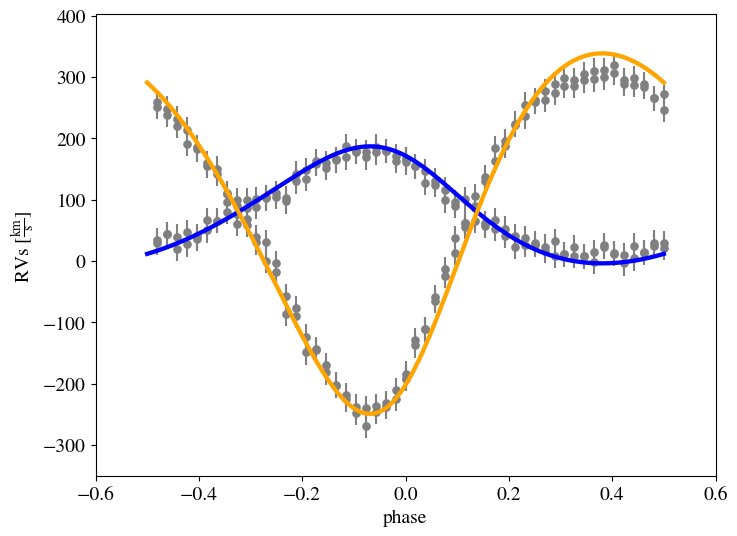

In [8]:
afig, mplfig = b.plot(solution='rv_geom_sol',
                      show=True, save='figure_rv_geometry.pdf')